In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")

In [2]:
df = pd.read_excel("Track_D_data_share.xlsx", sheet_name="All data")
df

Date Sample ID   Gln   Glu   Gluc    Lac   NH4+    Na+  \
0  2023-01-06 12:32:00      u1p0  8.25  2.08  36.56   0.00   0.65  120.2   
1  2023-01-06 11:25:00     u1p00  8.68  2.11  35.57   0.06   0.62  122.8   
2  2023-01-16 13:05:00     u1p10  3.85  4.50   6.50   4.71  28.26  115.7   
3  2023-01-09 12:57:00      u1p3  4.08  2.32  33.76   1.43   6.29  122.9   
4  2023-01-10 13:26:00      u1p4  2.18  2.46  31.22   1.44   9.22  122.4   
..                 ...       ...   ...   ...    ...    ...    ...    ...   
59 2023-01-09 14:30:00      u8p3  4.87  2.38  32.05   5.52   4.41  140.5   
60 2023-01-10 15:03:00      u8p4  3.38  2.47  28.44   8.92   6.45  142.1   
61 2023-01-11 14:18:00      u8p5  1.77  2.63  22.91  12.50   8.50  142.7   
62 2023-01-12 11:12:00      u8p6  3.14  2.76  14.79  16.58  10.97  142.9   
63 2023-01-13 11:06:00      u8p7  0.40  2.98   3.47  21.27  12.11  142.7   

       K+  IgG [mg/mL]  ...  Total (cells/ml) 1  Comment  \
0    9.88          NaN  ...            814000.0      0.0   
1   10.20          NaN  ...                 NaN      NaN   
2   12.75        153.3  ...           8350000.0      0.0   
3   10.85         13.0  ...                 NaN      NaN   
4   10.97         20.8  ...           2420000.0      0.0   
..    ...          ...  ...                 ...      ...   
59  10.61          NaN  ...           1200000.0      0.0   
60  10.72          NaN  ...           2380000.0      0.0   
61  10.73          NaN  ...           4440000.0      0.0   
62  10.49          NaN  ...           1380000.0      0.0   
63  10.41          NaN  ...           7540000.0      0.0   

   Estimated cell diameter (um)  Cell diameter standard deviation (um)  \
0                          13.0                                    5.5   
1                           NaN                                    NaN   
2                          11.2                                    6.5   
3                           NaN                                    NaN   
4                          13.4                                    6.2   
..                          ...                                    ...   
59                         13.9                                    7.1   
60                         13.6                                    6.9   
61                         13.7                                    6.7   
62                         13.3                                    7.3   
63                         13.2                                    7.5   

    (%) of cells in aggregates with five or more cells  \
0                                                 0.0    
1                                                 NaN    
2                                                 0.0    
3                                                 NaN    
4                                                 1.0    
..                                                ...    
59                                                0.0    
60                                                0.0    
61                                                0.0    
62                                                1.0    
63                                                2.0    

            Image method 2  Viability (%) 2  Live (cells/ml) 2  \
0   20230106-0008-4-u1p0-2             95.6           807000.0   
1                      NaN              NaN                NaN   
2    20230116-0005-1-u1p10             67.2          7210000.0   
3     20230109-0003-5-u1p3             94.7          2660000.0   
4     20230110-0011-6-u8p4             94.2          2310000.0   
..                     ...              ...                ...   
59    20230109-0004-8-u8p3             90.9          1140000.0   
60    20230110-0012-6-u8p4             93.8          2300000.0   
61    20230111-0008-6-u8p5             98.2          4230000.0   
62    20230112-0003-6-u8p6             89.3          5260000.0   
63    20230113-0004-6-u6p7             83.7          7700000.0   

    D

In [3]:
# create a column for reactor and day
df['Reactor [#]'] = df['Sample ID'].apply(lambda x: x.split("p")[0])
df['Time [d]'] = (df['Date'].dt.day - df.iloc[0,0].day).astype('category')

start_time_per_reactor = df.groupby('Reactor [#]').apply(lambda x: x.Date.min())
df['Time [h]'] = df.apply(lambda x: (x.Date-start_time_per_reactor[x['Reactor [#]']]).total_seconds()/60/60, axis=1)

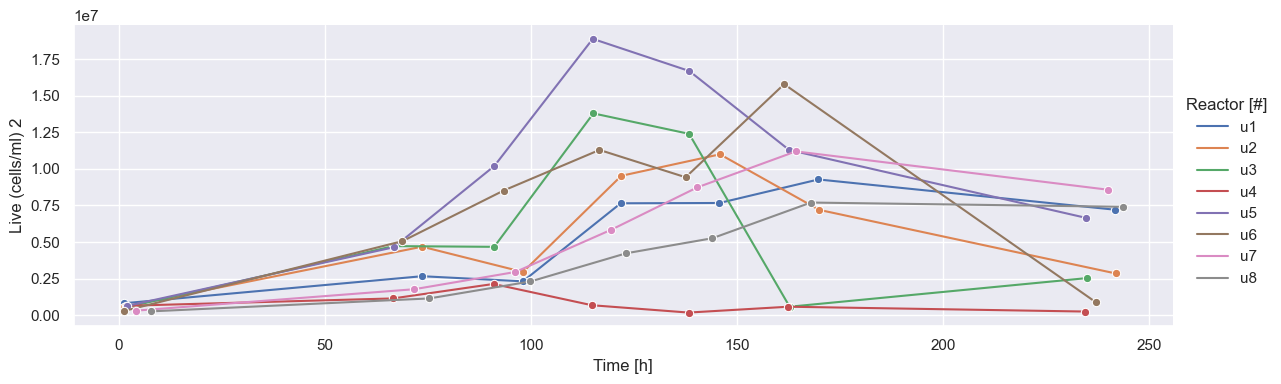

In [4]:
sns.relplot(data=df, x="Time [h]", y="Live (cells/ml) 2", hue='Reactor [#]', kind='line', marker='o', height=4, aspect=3, hue_order=sorted(df['Reactor [#]'].unique()))

In [5]:
5*24

120

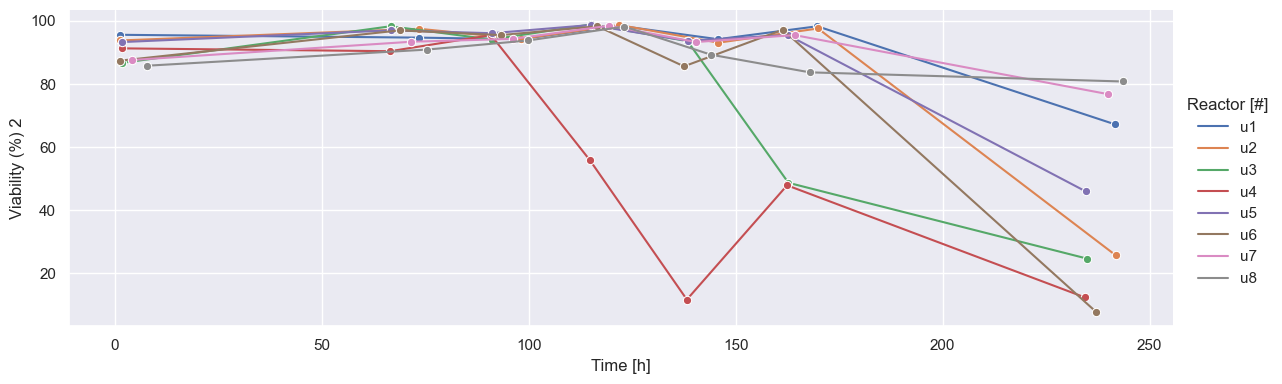

In [6]:
g = sns.relplot(data=df, x="Time [h]", y="Viability (%) 2", hue='Reactor [#]', kind='line', marker='o', height=4, aspect=3, hue_order=sorted(df['Reactor [#]'].unique()))

In [7]:
def specific_growth_rate(g):
    g = g.sort_values(by='Date')
    sgr = pd.Series([0, *[np.log(g['Live (cells/ml) 2'].iloc[i+1]/g['Live (cells/ml) 2'].iloc[i])/((g['Time [h]'].iloc[i+1]-g['Time [h]'].iloc[i])/24) for i in range(len(g)-1)]])
    sgr.index = g.index
    g['sgr [day^-1]'] = sgr
    return g

def doubling_time(g):
    #=((A7-A6)*LN(2))/LN(D7/D6)
    g = g.sort_values(by='Date')
    dt = pd.Series([0, *[((g['Time [h]'].iloc[i+1]-g['Time [h]'].iloc[i])*np.log(2))/np.log(g['Live (cells/ml) 2'].iloc[i+1]/g['Live (cells/ml) 2'].iloc[i]) for i in range(len(g)-1)]])
    dt.index = g.index
    g['doubling time [h]'] = dt
    return g
        
df = df.groupby("Reactor [#]", group_keys=False).apply(specific_growth_rate)
df = df.groupby("Reactor [#]", group_keys=False).apply(doubling_time)
df.head()

Date Sample ID   Gln   Glu   Gluc   Lac   NH4+    Na+     K+  \
1 2023-01-06 11:25:00     u1p00  8.68  2.11  35.57  0.06   0.62  122.8  10.20   
0 2023-01-06 12:32:00      u1p0  8.25  2.08  36.56  0.00   0.65  120.2   9.88   
3 2023-01-09 12:57:00      u1p3  4.08  2.32  33.76  1.43   6.29  122.9  10.85   
4 2023-01-10 13:26:00      u1p4  2.18  2.46  31.22  1.44   9.22  122.4  10.97   
5 2023-01-11 13:09:00      u1p5  2.72  2.63  25.92  1.31  12.81  120.1  10.90   

   IgG [mg/mL]  ...          Image method 2  Viability (%) 2  \
1          NaN  ...                     NaN              NaN   
0          NaN  ...  20230106-0008-4-u1p0-2             95.6   
3         13.0  ...    20230109-0003-5-u1p3             94.7   
4         20.8  ...    20230110-0011-6-u8p4             94.2   
5         31.0  ...  20230111-0007-3-u1p5-2             98.5   

  Live (cells/ml) 2  Dead (cells/ml) 2  Total (cells / ml) 2  Reactor [#]  \
1               NaN                NaN                   NaN           u1   
0          807000.0            37000.0              844000.0           u1   
3         2660000.0           150000.0             2810000.0           u1   
4         2310000.0           143000.0             2450000.0           u1   
5         7650000.0           120000.0             7770000.0           u1   

   Time [d]    Time [h]  sgr [day^-1]  doubling time [h]  
1         0    0.000000      0.000000           0.000000  
0         0    1.116667           NaN                NaN  
3         3   73.533333      0.395298          42.083490  
4         4   98.016667     -0.138294        -120.291481  
5         5  121.733333      1.211764          13.728364  

[5 rows x 31 columns]

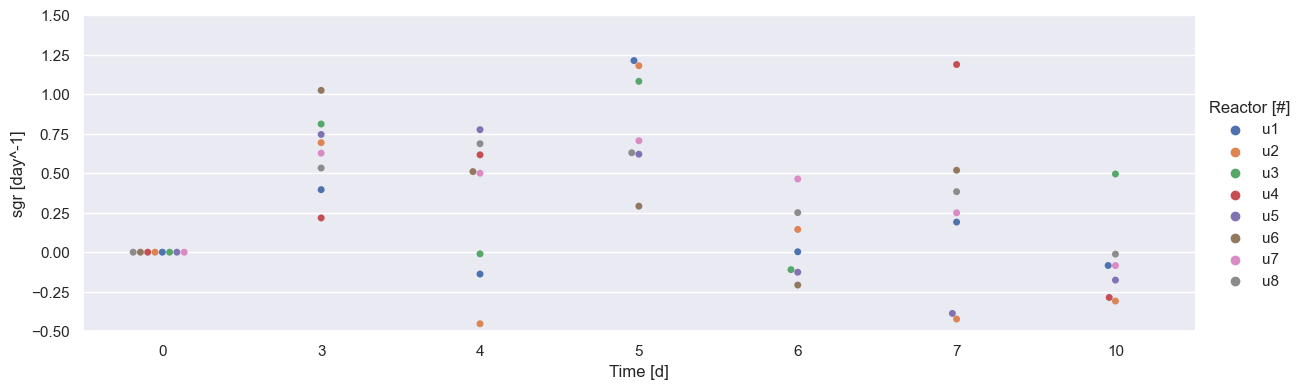

In [8]:
g = sns.catplot(data=df, hue="Reactor [#]", y="sgr [day^-1]", kind='swarm', x='Time [d]', height=4, aspect=3)
g.set(ylim=(-0.5, 1.5))

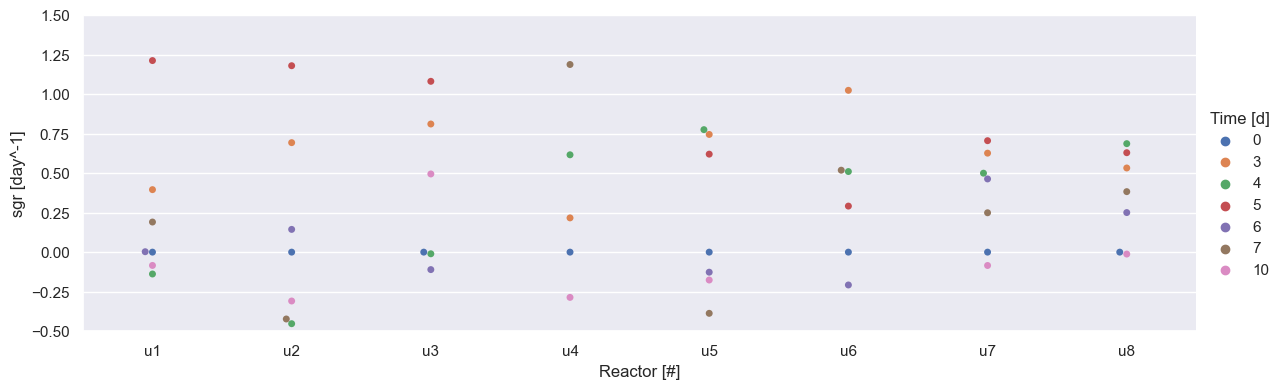

In [9]:
g = sns.catplot(data=df, x="Reactor [#]", y="sgr [day^-1]", kind='swarm', hue='Time [d]', height=4, aspect=3)
g.set(ylim=(-0.5, 1.5))

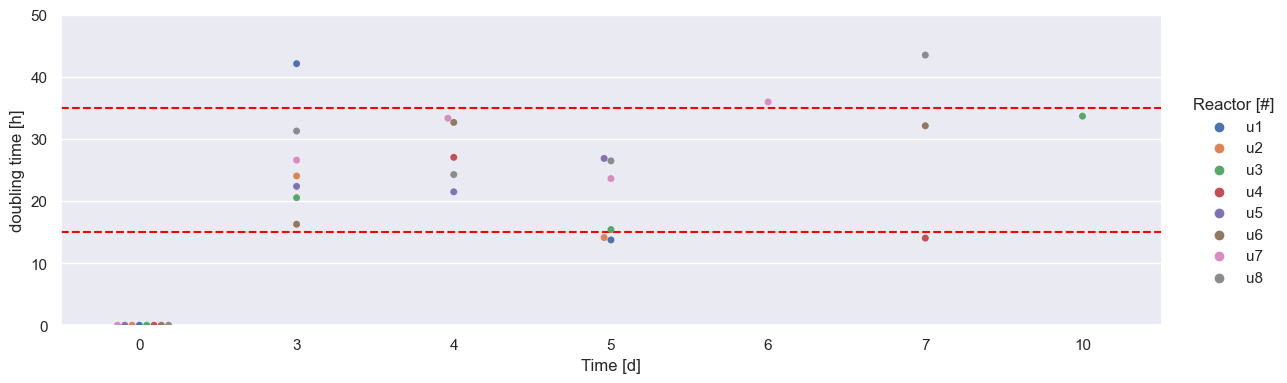

In [10]:
g = sns.catplot(data=df, hue="Reactor [#]", y="doubling time [h]", kind='swarm', x='Time [d]', height=4, aspect=3)
g.set(ylim=(-0, 50))
g.refline(y=35, color='red')
g.refline(y=15, color='red')

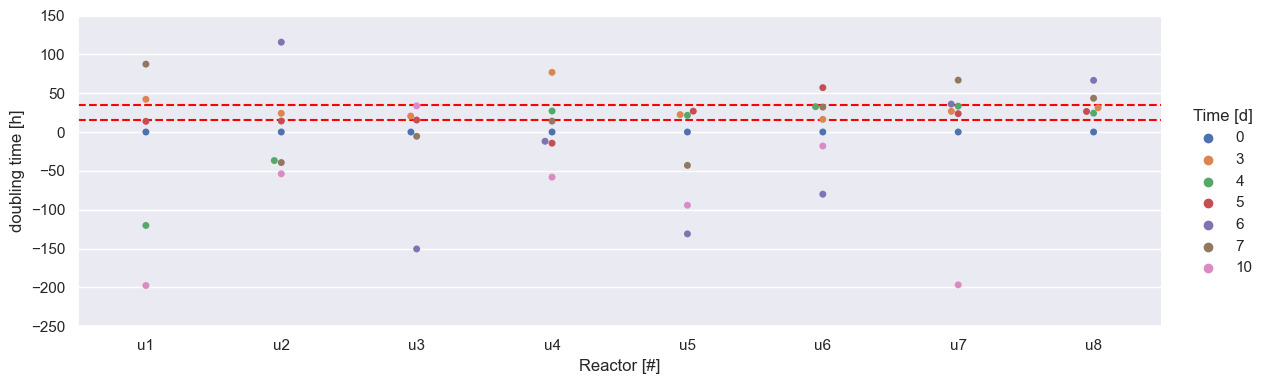

In [11]:
g = sns.catplot(data=df, x="Reactor [#]", y="doubling time [h]", kind='swarm', hue='Time [d]', height=4, aspect=3)
g.set(ylim=(-250, 150))
g.refline(y=35, color='red')
g.refline(y=15, color='red')

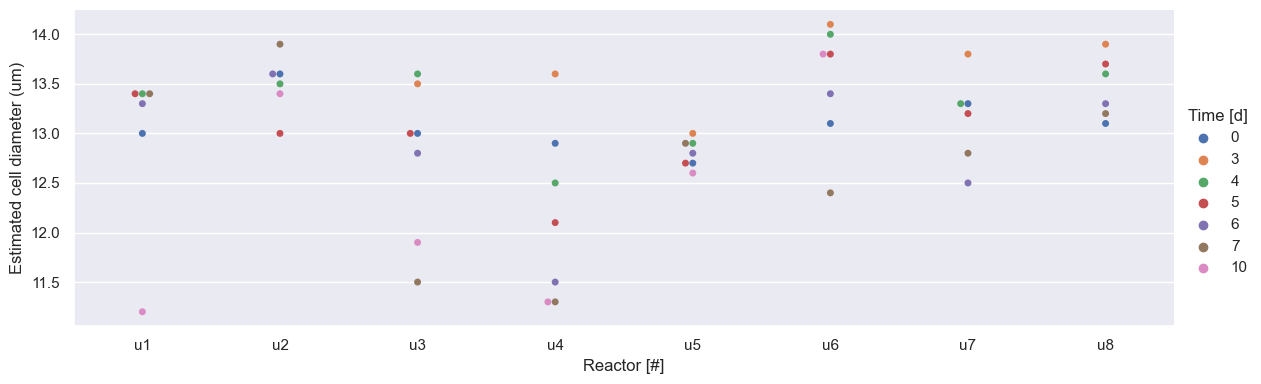

In [12]:
g = sns.catplot(data=df, x="Reactor [#]", y="Estimated cell diameter (um)", kind='swarm', hue='Time [d]', height=4, aspect=3)

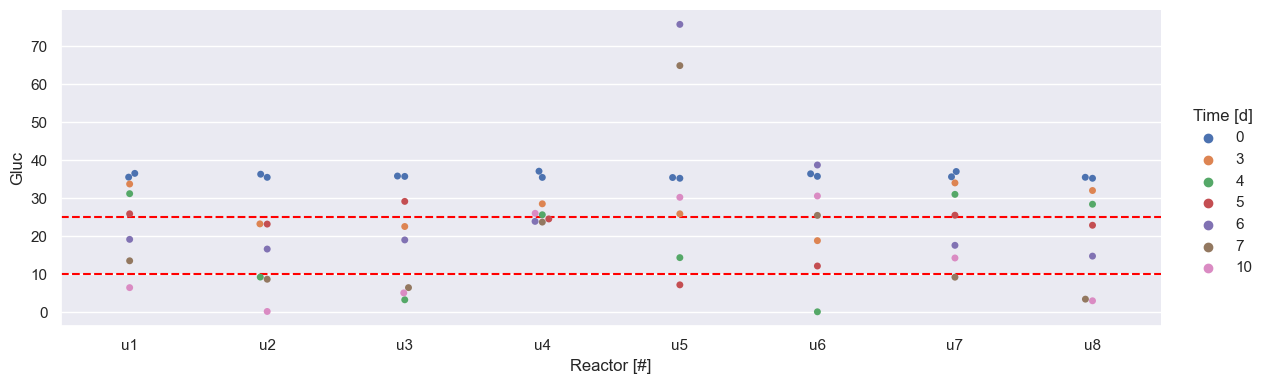

In [13]:
g = sns.catplot(data=df, x="Reactor [#]", y="Gluc", kind='swarm', hue='Time [d]', height=4, aspect=3)
g.refline(y = 10, color='red')
g.refline(y = 25, color='red')

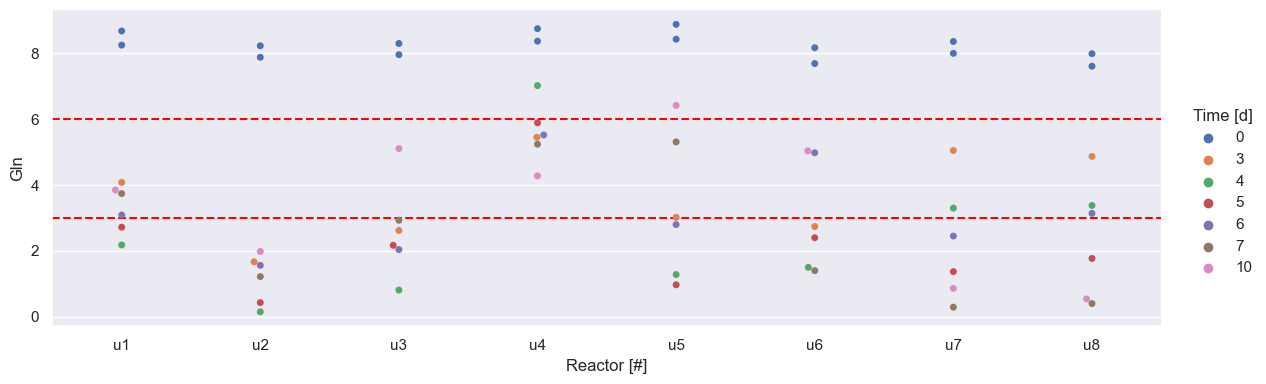

In [14]:
g = sns.catplot(data=df, x="Reactor [#]", y="Gln", kind='swarm', hue='Time [d]', height=4, aspect=3)
g.refline(y = 3, color='red')
g.refline(y = 6, color='red')

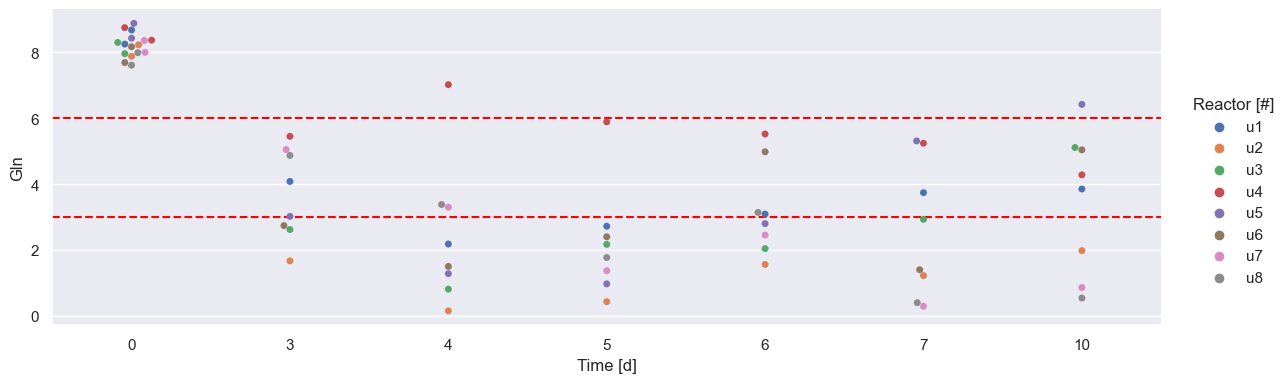

In [15]:
g = sns.catplot(data=df, hue="Reactor [#]", y="Gln", kind='swarm', x='Time [d]', height=4, aspect=3)
g.refline(y = 3, color='red')
g.refline(y = 6, color='red')

In [16]:
df.columns

Index(['Date', 'Sample ID', 'Gln', 'Glu', 'Gluc', 'Lac', 'NH4+', 'Na+', 'K+',
       'IgG [mg/mL]', 'Gluc fed [mL of 2220 mM stock]',
       'Gln fed [mL of 200 mM stock]', 'Image method 1', 'Viability (%) 1',
       'Live (cells/ml) 1', 'Dead (cells/ml) 1', 'Total (cells/ml) 1',
       'Comment', 'Estimated cell diameter (um)',
       'Cell diameter standard deviation (um)',
       '(%) of cells in aggregates with five or more cells', 'Image method 2',
       'Viability (%) 2', 'Live (cells/ml) 2', 'Dead (cells/ml) 2',
       'Total (cells / ml) 2', 'Reactor [#]', 'Time [d]', 'Time [h]',
       'sgr [day^-1]', 'doubling time [h]'],
      dtype='object')

In [17]:
long_format = df[['Reactor [#]', 'Time [h]', 'Gln', 'Glu', 'Gluc', 'Lac', 'NH4+', 'Na+', 'K+', 'IgG [mg/mL]']].melt(id_vars=['Reactor [#]', 'Time [h]'])
long_format.head()

Reactor [#]    Time [h] variable  value
0          u1    0.000000      Gln   8.68
1          u1    1.116667      Gln   8.25
2          u1   73.533333      Gln   4.08
3          u1   98.016667      Gln   2.18
4          u1  121.733333      Gln   2.72

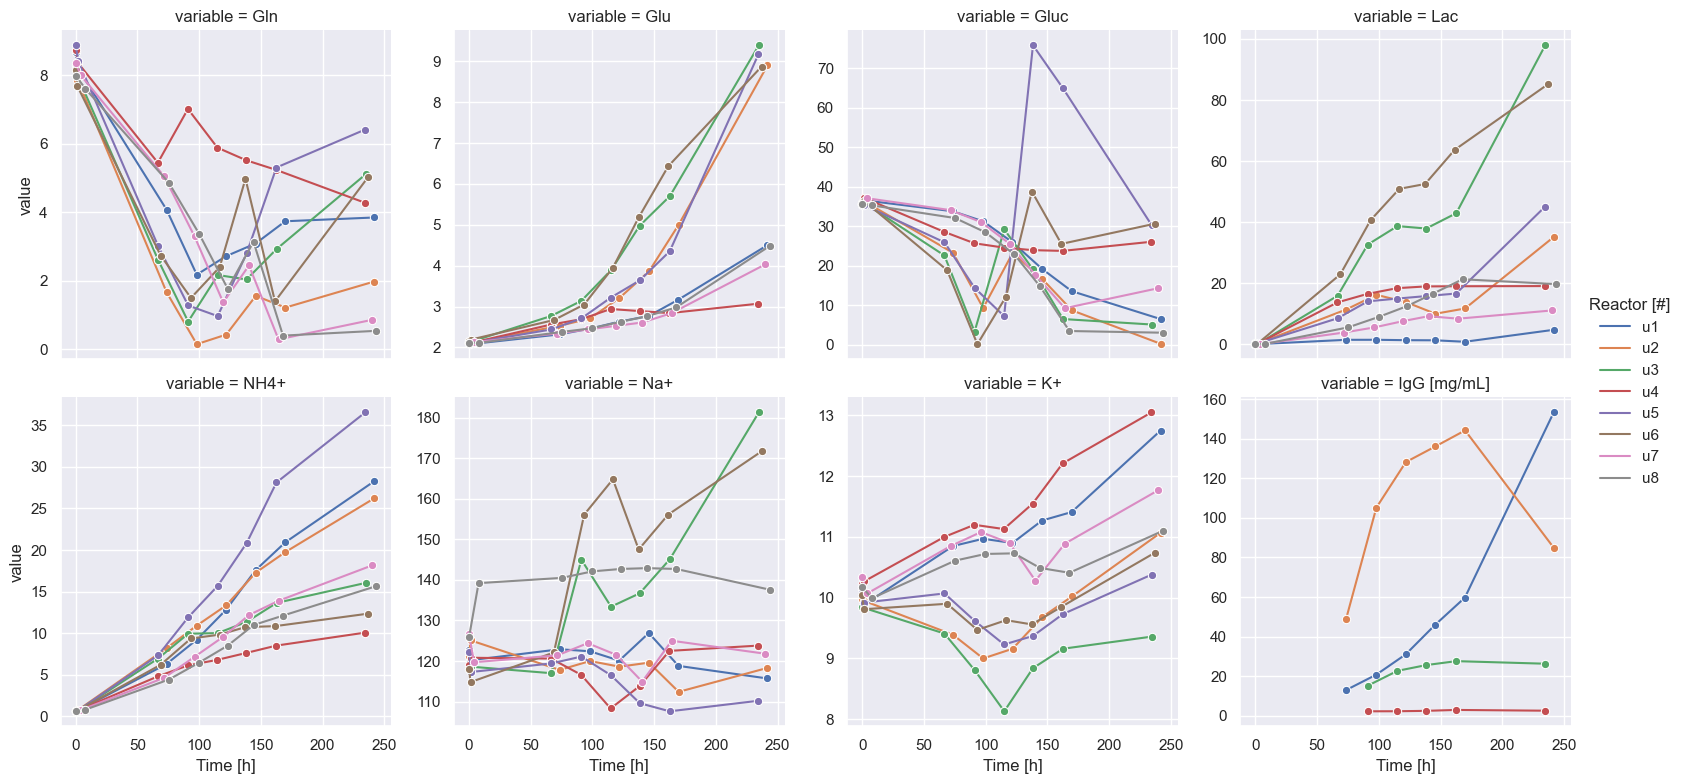

In [18]:
sns.relplot(data=long_format, x="Time [h]", y='value', hue='Reactor [#]', col='variable', col_wrap=4, facet_kws={'sharey': False, 'sharex': True}, kind='line', marker='o', height=4)

In [19]:
volume_mL = 0.28E3

def ivcd(g):
    g = g.sort_values(by='Date')
    ivcd = pd.Series([0, *[0.5*(g['Live (cells/ml) 2'].iloc[i+1]+g['Live (cells/ml) 2'].iloc[i])*volume_mL*((g['Time [h]'].iloc[i+1]-g['Time [h]'].iloc[i])/24) for i in range(len(g)-1)]])
    ivcd.index = g.index
    g['ivcd [cell*day]'] = ivcd
    return g

df = df.groupby("Reactor [#]", group_keys=False).apply(ivcd)
df.head()

Date Sample ID   Gln   Glu   Gluc   Lac   NH4+    Na+     K+  \
1 2023-01-06 11:25:00     u1p00  8.68  2.11  35.57  0.06   0.62  122.8  10.20   
0 2023-01-06 12:32:00      u1p0  8.25  2.08  36.56  0.00   0.65  120.2   9.88   
3 2023-01-09 12:57:00      u1p3  4.08  2.32  33.76  1.43   6.29  122.9  10.85   
4 2023-01-10 13:26:00      u1p4  2.18  2.46  31.22  1.44   9.22  122.4  10.97   
5 2023-01-11 13:09:00      u1p5  2.72  2.63  25.92  1.31  12.81  120.1  10.90   

   IgG [mg/mL]  ...  Viability (%) 2  Live (cells/ml) 2 Dead (cells/ml) 2  \
1          NaN  ...              NaN                NaN               NaN   
0          NaN  ...             95.6           807000.0           37000.0   
3         13.0  ...             94.7          2660000.0          150000.0   
4         20.8  ...             94.2          2310000.0          143000.0   
5         31.0  ...             98.5          7650000.0          120000.0   

   Total (cells / ml) 2  Reactor [#]  Time [d]    Time [h]  sgr [day^-1]  \
1                   NaN           u1         0    0.000000      0.000000   
0              844000.0           u1         0    1.116667           NaN   
3             2810000.0           u1         3   73.533333      0.395298   
4             2450000.0           u1         4   98.016667     -0.138294   
5             7770000.0           u1         5  121.733333      1.211764   

   doubling time [h]  ivcd [cell*day]  
1           0.000000     0.000000e+00  
0                NaN              NaN  
3          42.083490     1.464567e+09  
4        -120.291481     7.098126e+08  
5          13.728364     1.377938e+09  

[5 rows x 32 columns]

/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmPr

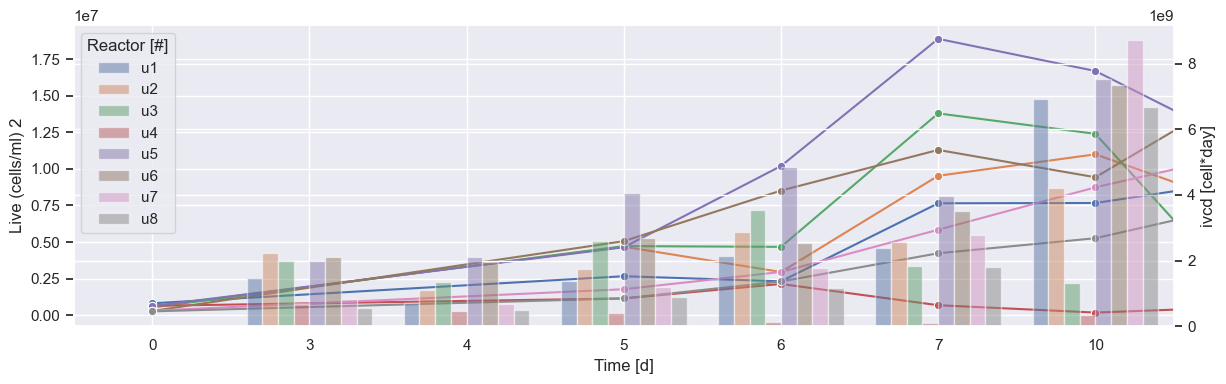

In [20]:
g = sns.relplot(data=df, x="Time [d]", y="Live (cells/ml) 2", hue='Reactor [#]', kind='line', marker='o', legend=False, height=4, aspect=3)
g2 = sns.barplot(data=df, x="Time [d]", y='ivcd [cell*day]', hue='Reactor [#]', alpha=0.5, ax=g.axes[0][0].twinx())

In [21]:
volume_L = 0.28

def pcd(g):
    g = g.sort_values(by='Date')
    pcd = pd.Series([0, *[((g['IgG [mg/mL]'].iloc[i+1]-g['IgG [mg/mL]'].iloc[i])*volume_L*1E9)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    pcd.index = g.index
    g['pcd [pg/cell/day]'] = pcd
    return g

df = df.groupby("Reactor [#]", group_keys=False).apply(pcd)
df.head()

Date Sample ID   Gln   Glu   Gluc   Lac   NH4+    Na+     K+  \
1 2023-01-06 11:25:00     u1p00  8.68  2.11  35.57  0.06   0.62  122.8  10.20   
0 2023-01-06 12:32:00      u1p0  8.25  2.08  36.56  0.00   0.65  120.2   9.88   
3 2023-01-09 12:57:00      u1p3  4.08  2.32  33.76  1.43   6.29  122.9  10.85   
4 2023-01-10 13:26:00      u1p4  2.18  2.46  31.22  1.44   9.22  122.4  10.97   
5 2023-01-11 13:09:00      u1p5  2.72  2.63  25.92  1.31  12.81  120.1  10.90   

   IgG [mg/mL]  ...  Live (cells/ml) 2  Dead (cells/ml) 2  \
1          NaN  ...                NaN                NaN   
0          NaN  ...           807000.0            37000.0   
3         13.0  ...          2660000.0           150000.0   
4         20.8  ...          2310000.0           143000.0   
5         31.0  ...          7650000.0           120000.0   

  Total (cells / ml) 2  Reactor [#]  Time [d]    Time [h]  sgr [day^-1]  \
1                  NaN           u1         0    0.000000      0.000000   
0             844000.0           u1         0    1.116667           NaN   
3            2810000.0           u1         3   73.533333      0.395298   
4            2450000.0           u1         4   98.016667     -0.138294   
5            7770000.0           u1         5  121.733333      1.211764   

   doubling time [h]  ivcd [cell*day]  pcd [pg/cell/day]  
1           0.000000     0.000000e+00           0.000000  
0                NaN              NaN                NaN  
3          42.083490     1.464567e+09                NaN  
4        -120.291481     7.098126e+08           3.076868  
5          13.728364     1.377938e+09           2.072662  

[5 rows x 33 columns]

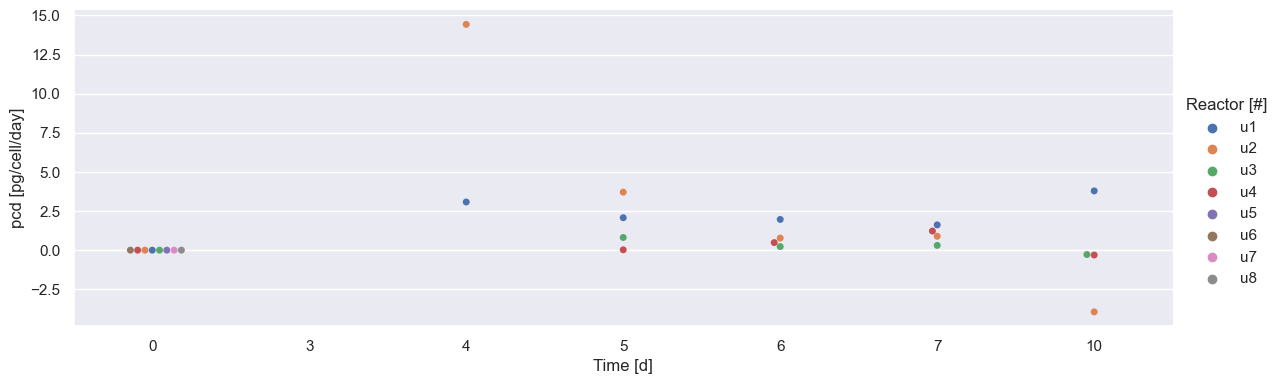

In [22]:
sns.catplot(data=df, hue="Reactor [#]", y="pcd [pg/cell/day]", kind='swarm', x='Time [d]', height=4, aspect=3)

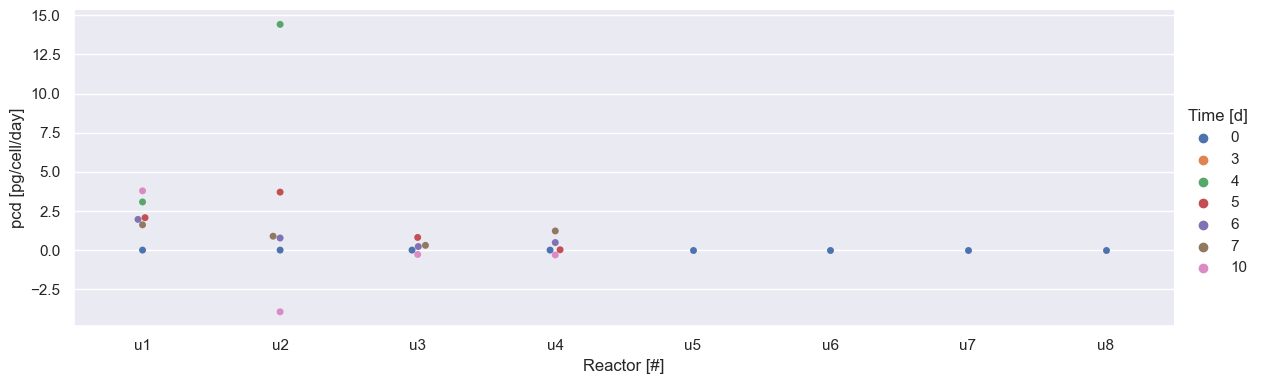

In [23]:
sns.catplot(data=df, x="Reactor [#]", y="pcd [pg/cell/day]", kind='swarm', hue='Time [d]', height=4, aspect=3)

In [24]:
df.columns

Index(['Date', 'Sample ID', 'Gln', 'Glu', 'Gluc', 'Lac', 'NH4+', 'Na+', 'K+',
       'IgG [mg/mL]', 'Gluc fed [mL of 2220 mM stock]',
       'Gln fed [mL of 200 mM stock]', 'Image method 1', 'Viability (%) 1',
       'Live (cells/ml) 1', 'Dead (cells/ml) 1', 'Total (cells/ml) 1',
       'Comment', 'Estimated cell diameter (um)',
       'Cell diameter standard deviation (um)',
       '(%) of cells in aggregates with five or more cells', 'Image method 2',
       'Viability (%) 2', 'Live (cells/ml) 2', 'Dead (cells/ml) 2',
       'Total (cells / ml) 2', 'Reactor [#]', 'Time [d]', 'Time [h]',
       'sgr [day^-1]', 'doubling time [h]', 'ivcd [cell*day]',
       'pcd [pg/cell/day]'],
      dtype='object')

In [25]:
# NON FED 'Glu','Lac', 'NH4+', 'Na+', 'K+','IgG [mg/mL]', 

def spec_proc_non_fed(g):
    g = g.sort_values(by='Date')
    spec_proc_glu = pd.Series([0, *[((g['Glu'].iloc[i+1]-g['Glu'].iloc[i])*volume_L*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_lac = pd.Series([0, *[((g['Lac'].iloc[i+1]-g['Lac'].iloc[i])*volume_L*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_nh4 = pd.Series([0, *[((g['NH4+'].iloc[i+1]-g['NH4+'].iloc[i])*volume_L*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_na = pd.Series([0, *[((g['Na+'].iloc[i+1]-g['Na+'].iloc[i])*volume_L*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_k = pd.Series([0, *[((g['K+'].iloc[i+1]-g['K+'].iloc[i])*volume_L*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    
    spec_proc_glu.index = g.index
    spec_proc_lac.index = g.index
    spec_proc_nh4.index = g.index
    spec_proc_na.index = g.index
    spec_proc_k.index = g.index
    
    g['spec_proc (glu) [nM/cell/day]'] = spec_proc_glu
    g['spec_proc (lac) [nM/cell/day]'] = spec_proc_lac
    g['spec_proc (NH4) [nM/cell/day]'] = spec_proc_nh4
    g['spec_proc (Na+) [nM/cell/day]'] = spec_proc_na
    g['spec_proc (K+) [nM/cell/day]'] = spec_proc_k
    return g

df = df.groupby("Reactor [#]", group_keys=False).apply(spec_proc_non_fed)
df.head()

Date Sample ID   Gln   Glu   Gluc   Lac   NH4+    Na+     K+  \
1 2023-01-06 11:25:00     u1p00  8.68  2.11  35.57  0.06   0.62  122.8  10.20   
0 2023-01-06 12:32:00      u1p0  8.25  2.08  36.56  0.00   0.65  120.2   9.88   
3 2023-01-09 12:57:00      u1p3  4.08  2.32  33.76  1.43   6.29  122.9  10.85   
4 2023-01-10 13:26:00      u1p4  2.18  2.46  31.22  1.44   9.22  122.4  10.97   
5 2023-01-11 13:09:00      u1p5  2.72  2.63  25.92  1.31  12.81  120.1  10.90   

   IgG [mg/mL]  ...    Time [h]  sgr [day^-1] doubling time [h]  \
1          NaN  ...    0.000000      0.000000          0.000000   
0          NaN  ...    1.116667           NaN               NaN   
3         13.0  ...   73.533333      0.395298         42.083490   
4         20.8  ...   98.016667     -0.138294       -120.291481   
5         31.0  ...  121.733333      1.211764         13.728364   

   ivcd [cell*day]  pcd [pg/cell/day]  spec_proc (glu) [nM/cell/day]  \
1     0.000000e+00           0.000000                       0.000000   
0              NaN                NaN                            NaN   
3     1.464567e+09                NaN                       0.000046   
4     7.098126e+08           3.076868                       0.000055   
5     1.377938e+09           2.072662                       0.000035   

   spec_proc (lac) [nM/cell/day]  spec_proc (NH4) [nM/cell/day]  \
1                       0.000000                       0.000000   
0                            NaN                            NaN   
3                       0.000273                       0.001078   
4                       0.000004                       0.001156   
5                      -0.000026                       0.000729   

   spec_proc (Na+) [nM/cell/day]  spec_proc (K+) [nM/cell/day]  
1                       0.000000                      0.000000  
0                            NaN                           NaN  
3                       0.000516                      0.000185  
4                      -0.000197                      0.000047  
5                      -0.000467                     -0.000014  

[5 rows x 38 columns]

In [26]:
long_format = df[['Reactor [#]', 'Time [h]', 'spec_proc (glu) [nM/cell/day]', 'spec_proc (lac) [nM/cell/day]', 'spec_proc (NH4) [nM/cell/day]', 'spec_proc (Na+) [nM/cell/day]', 'spec_proc (K+) [nM/cell/day]','pcd [pg/cell/day]']].melt(id_vars=['Reactor [#]', 'Time [h]'])
long_format.head()

Reactor [#]    Time [h]                       variable     value
0          u1    0.000000  spec_proc (glu) [nM/cell/day]  0.000000
1          u1    1.116667  spec_proc (glu) [nM/cell/day]       NaN
2          u1   73.533333  spec_proc (glu) [nM/cell/day]  0.000046
3          u1   98.016667  spec_proc (glu) [nM/cell/day]  0.000055
4          u1  121.733333  spec_proc (glu) [nM/cell/day]  0.000035

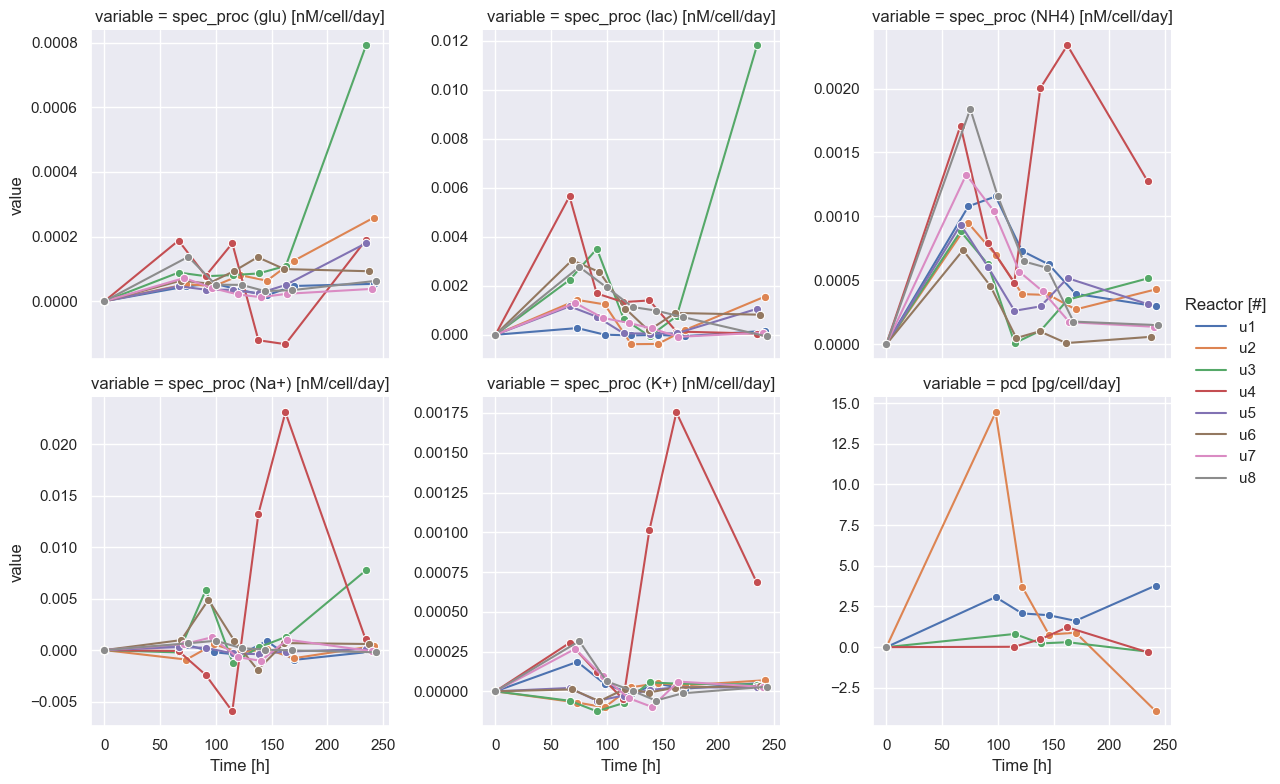

In [27]:
sns.relplot(data=long_format, x="Time [h]", y='value', hue='Reactor [#]', col='variable', col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, kind='line', marker='o', height=4)

In [28]:
# FED 'Gln', 'Gluc', 
# 'Gluc fed [mL of 2220 mM stock]', #'Gln fed [mL of 200 mM stock]', 

#'Reactor [#]', 'Time [d]', 'Time [h]',    
#'sgr [day^-1]', 'doubling time [h]', 'ivcd [cell*day]',
#'pcd [pg/cell/day]'

In [29]:
gluc_stock_conc = 2220 # mM
gln_stock_conc = 200 # mM

def spec_proc_active_fed(g):
    g = g.sort_values(by='Date')
    values_gluc = [0]
    values_gln = [0]
    for i in range(len(g)-1):
        current_measurement_gluc = g['Gluc'].iloc[i] * volume_L # mmol
        current_measurement_gln = g['Gln'].iloc[i] * volume_L # mmol
        # was it fed?
        fed_ml_gluc = g['Gluc fed [mL of 2220 mM stock]'].iloc[i]
        fed_ml_gln = g['Gln fed [mL of 200 mM stock]'].iloc[i]
        if fed_ml_gluc > 0:
            #yes, then add the fed amount
            mmol_fed_gluc = fed_ml_gluc*gluc_stock_conc * 1E-3 # mL * mM * 1E-3 = mmol
            current_measurement_gluc += mmol_fed_gluc
        if fed_ml_gln > 0:
            mmol_fed_gln = fed_ml_gln*gln_stock_conc * 1E-3 # mL * mM * 1E-3 = mmol
            current_measurement_gln += mmol_fed_gln
        next_measurement_gluc = g['Gluc'].iloc[i+1] * volume_L # mmol
        next_measurement_gln = g['Gln'].iloc[i+1] * volume_L # mmol
        
        values_gluc.append(abs(((next_measurement_gluc-current_measurement_gluc)*1E6)/g['ivcd [cell*day]'].iloc[i+1]))
        values_gln.append(abs(((next_measurement_gln-current_measurement_gln)*1E6)/g['ivcd [cell*day]'].iloc[i+1]))
        
    spec_proc_gluc = pd.Series(values_gluc)
    spec_proc_gluc.index = g.index
    spec_proc_gln = pd.Series(values_gln)
    spec_proc_gln.index = g.index
    g['spec_proc (gluc) [nM/cell/day]'] = spec_proc_gluc
    g['spec_proc (gln) [nM/cell/day]'] = spec_proc_gln
    return g

df = df.groupby("Reactor [#]", group_keys=False).apply(spec_proc_active_fed)
df.head()

Date Sample ID   Gln   Glu   Gluc   Lac   NH4+    Na+     K+  \
1 2023-01-06 11:25:00     u1p00  8.68  2.11  35.57  0.06   0.62  122.8  10.20   
0 2023-01-06 12:32:00      u1p0  8.25  2.08  36.56  0.00   0.65  120.2   9.88   
3 2023-01-09 12:57:00      u1p3  4.08  2.32  33.76  1.43   6.29  122.9  10.85   
4 2023-01-10 13:26:00      u1p4  2.18  2.46  31.22  1.44   9.22  122.4  10.97   
5 2023-01-11 13:09:00      u1p5  2.72  2.63  25.92  1.31  12.81  120.1  10.90   

   IgG [mg/mL]  ...  doubling time [h]  ivcd [cell*day] pcd [pg/cell/day]  \
1          NaN  ...           0.000000     0.000000e+00          0.000000   
0          NaN  ...                NaN              NaN               NaN   
3         13.0  ...          42.083490     1.464567e+09               NaN   
4         20.8  ...        -120.291481     7.098126e+08          3.076868   
5         31.0  ...          13.728364     1.377938e+09          2.072662   

   spec_proc (glu) [nM/cell/day]  spec_proc (lac) [nM/cell/day]  \
1                       0.000000                       0.000000   
0                            NaN                            NaN   
3                       0.000046                       0.000273   
4                       0.000055                       0.000004   
5                       0.000035                      -0.000026   

   spec_proc (NH4) [nM/cell/day]  spec_proc (Na+) [nM/cell/day]  \
1                       0.000000                       0.000000   
0                            NaN                            NaN   
3                       0.001078                       0.000516   
4                       0.001156                      -0.000197   
5                       0.000729                      -0.000467   

   spec_proc (K+) [nM/cell/day]  spec_proc (gluc) [nM/cell/day]  \
1                      0.000000                        0.000000   
0                           NaN                             NaN   
3                      0.000185                        0.000535   
4                      0.000047                        0.001002   
5                     -0.000014                        0.001077   

   spec_proc (gln) [nM/cell/day]  
1                       0.000000  
0                            NaN  
3                       0.000797  
4                       0.000749  
5                       0.000384  

[5 rows x 40 columns]

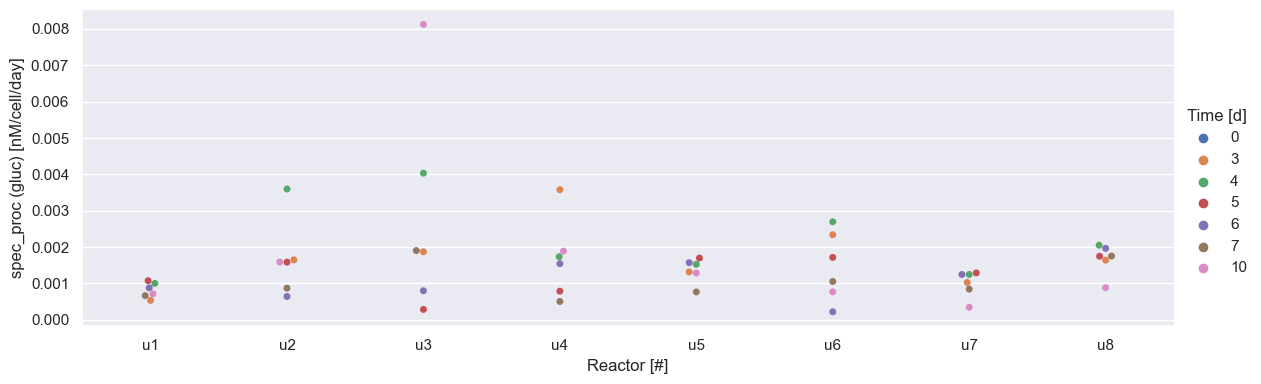

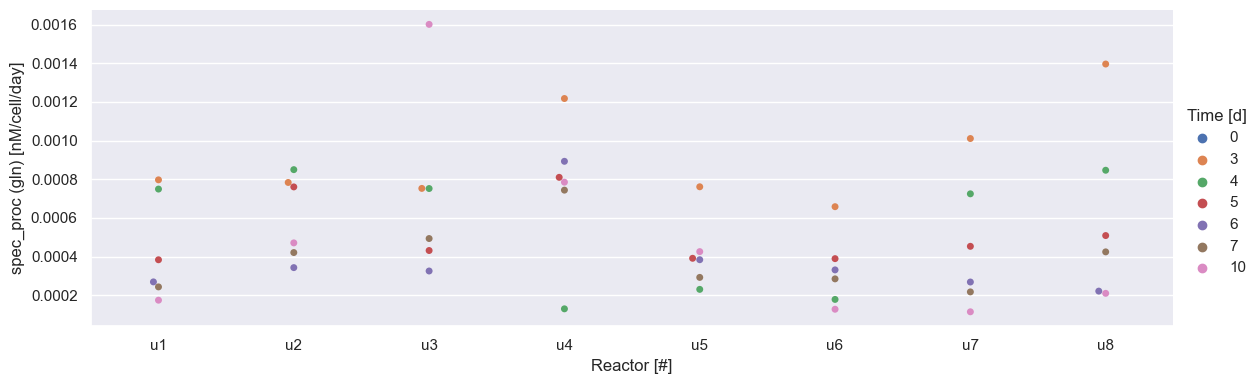

In [30]:
sns.catplot(data=df[df['Time [d]'] != 0], x="Reactor [#]", y="spec_proc (gluc) [nM/cell/day]", kind='swarm', hue='Time [d]', height=4, aspect=3)
sns.catplot(data=df[df['Time [d]'] != 0], x="Reactor [#]", y="spec_proc (gln) [nM/cell/day]", kind='swarm', hue='Time [d]', height=4, aspect=3)

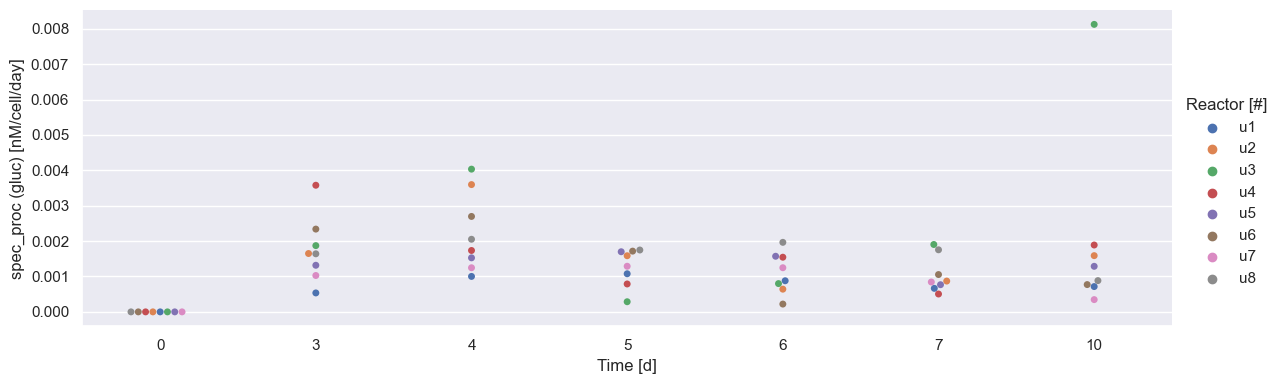

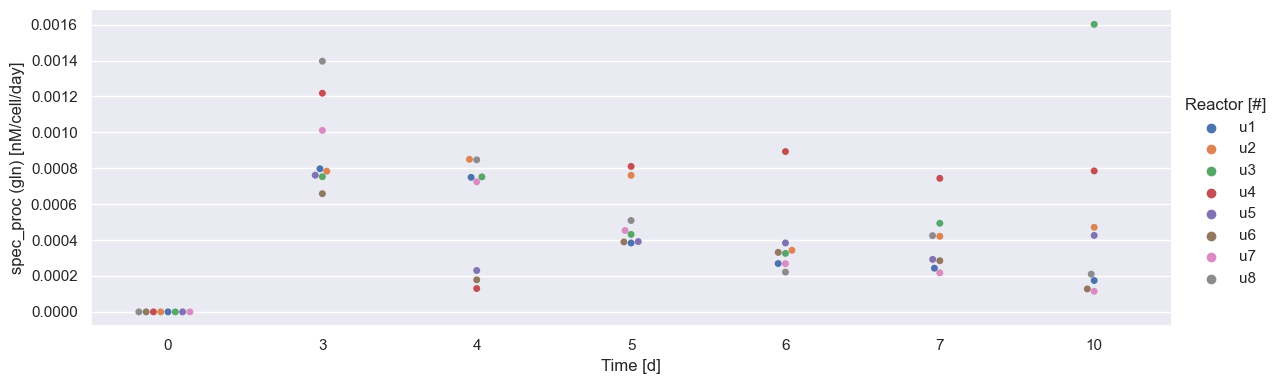

In [31]:
sns.catplot(data=df, hue="Reactor [#]", y="spec_proc (gluc) [nM/cell/day]", kind='swarm', x='Time [d]', height=4, aspect=3)
sns.catplot(data=df, hue="Reactor [#]", y="spec_proc (gln) [nM/cell/day]", kind='swarm', x='Time [d]', height=4, aspect=3)

In [32]:
#-----Predict-----#

In [39]:
# calc ivcd for next period based on previous period sgr (u)
# x(t) = x0 * e^(ut)
# u = ln(2)/dt

# time delta = 24 hours
# Scenario: We are at day 3, we want to predict day 4 in bioreactor 1

df[(df['Reactor [#]'] == 'u1') & (df['Time [d]'] == 3)]

Date Sample ID   Gln   Glu   Gluc   Lac  NH4+    Na+     K+  \
3 2023-01-09 12:57:00      u1p3  4.08  2.32  33.76  1.43  6.29  122.9  10.85   

   IgG [mg/mL]  ...  doubling time [h]  ivcd [cell*day] pcd [pg/cell/day]  \
3         13.0  ...           42.08349     1.464567e+09               NaN   

   spec_proc (glu) [nM/cell/day]  spec_proc (lac) [nM/cell/day]  \
3                       0.000046                       0.000273   

   spec_proc (NH4) [nM/cell/day]  spec_proc (Na+) [nM/cell/day]  \
3                       0.001078                       0.000516   

   spec_proc (K+) [nM/cell/day]  spec_proc (gluc) [nM/cell/day]  \
3                      0.000185                        0.000535   

   spec_proc (gln) [nM/cell/day]  
3                       0.000797  

[1 rows x 40 columns]

In [40]:
u = df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 3)]['sgr [day^-1]'].iloc[0]
x3 = df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 3)]['Live (cells/ml) 2'].iloc[0]
x4_pred = x3*np.e**u
x4_actual = df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 4)]['Live (cells/ml) 2'].iloc[0]
print(f"{x4_pred} <-> {x4_actual} > {x4_actual-x4_pred} ({(x4_actual-x4_pred)/x4_actual:.1%})")

9768838.124365376 <-> 10200000.0 > 431161.8756346237 (4.2%)


In [41]:
ivcd_pred = 0.5*(x4_pred+x3)*volume_mL
ivcd_actual = df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 4)]['ivcd [cell*day]'].iloc[0]
print(f"{ivcd_pred} <-> {ivcd_actual} > {ivcd_actual-ivcd_pred} ({(ivcd_actual-ivcd_pred)/ivcd_actual:.1%})")

2017237337.4111526 <-> 2112226666.666666 > 94989329.25551343 (4.5%)


In [42]:
scg = -df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 3)]['spec_proc (gluc) [nM/cell/day]'].iloc[0]
delta_gluc_3_to_4 = ivcd_pred*scg/1E6
gluc_day_3 = df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 3)]['Gluc'].iloc[0]

gluc_4_pred = gluc_day_3 + delta_gluc_3_to_4
gluc_4_actual = df[(df['Reactor [#]'] == 'u5') & (df['Time [d]'] == 4)]['Gluc'].iloc[0]
print(f"{gluc_4_pred} <-> {gluc_4_actual} > {gluc_4_actual-gluc_4_pred} ({(gluc_4_actual-gluc_4_pred)/gluc_4_actual:.1%})")

23.252902863476404 <-> 14.39 > -8.862902863476403 (-61.6%)


In [43]:
gluc_4_actual

14.39

In [44]:
### reactor condition recommendations

In [45]:
parameters = pd.DataFrame({
    'u1': {'rpm': 150,'pH':6.8,'pO':0.2},
    'u2': {'rpm': 150,'pH':7.0,'pO':0.6},
    'u3': {'rpm': 200,'pH':7.2,'pO':0.4},
    'u4': {'rpm': 200,'pH':6.8,'pO':0.2},
    'u5': {'rpm': 250,'pH':7.0,'pO':0.6},
    'u6': {'rpm': 250,'pH':7.2,'pO':0.4},
    'u7': {'rpm': 300,'pH':6.8,'pO':0.2},
    'u8': {'rpm': 300,'pH':7.0,'pO':0.6}
})
parameters

u1     u2     u3     u4     u5     u6     u7     u8
rpm  150.0  150.0  200.0  200.0  250.0  250.0  300.0  300.0
pH     6.8    7.0    7.2    6.8    7.0    7.2    6.8    7.0
pO     0.2    0.6    0.4    0.2    0.6    0.4    0.2    0.6

In [46]:
df = df.merge(parameters.T, how='inner', left_on='Reactor [#]', right_index=True)

In [88]:
results = df.pivot_table(index='Reactor [#]', values=['rpm', 'pO', 'pH', 'Live (cells/ml) 2', 'IgG [mg/mL]'], aggfunc={'rpm': np.mean, 'pO': np.mean, 'pH': np.mean, 'Live (cells/ml) 2': np.sum, 'IgG [mg/mL]': np.max})
results.to_csv("pivot_res.csv")

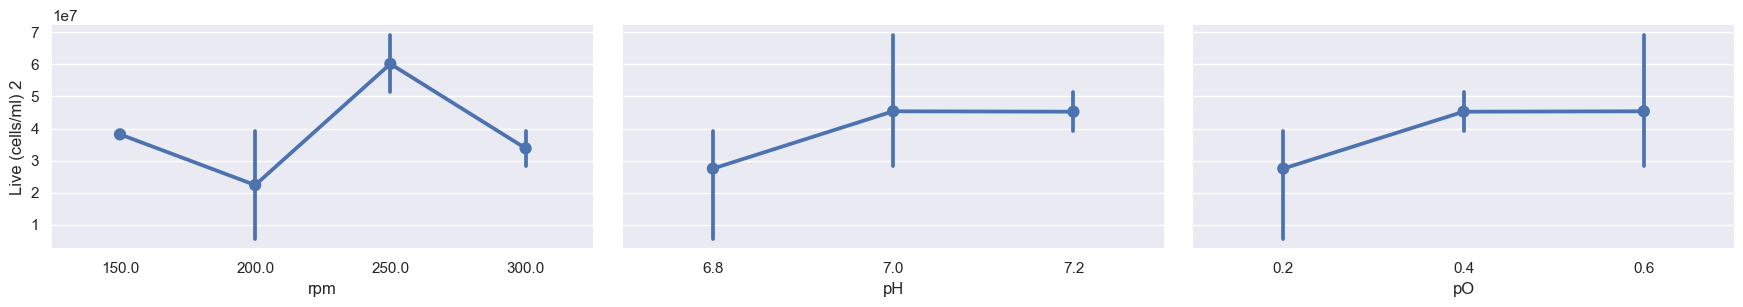

In [83]:
g = sns.PairGrid(results, y_vars="Live (cells/ml) 2", x_vars=["rpm", 'pH', 'pO'], height=3, aspect=2)
g.map(sns.pointplot)
sns.despine(fig=g.fig, left=True)

/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/laeb/PycharmProjects/track-d-calculations-27472/venv/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/laeb/Pycharm

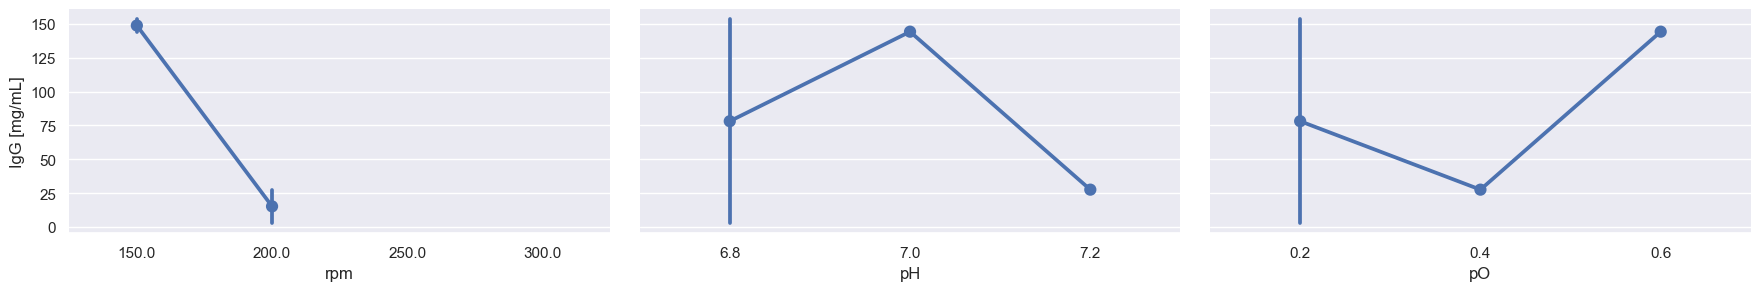

In [87]:
g = sns.PairGrid(results, y_vars="IgG [mg/mL]", x_vars=["rpm", 'pH', 'pO'], height=3, aspect=2)
g.map(sns.pointplot)
sns.despine(fig=g.fig, left=True)

In [53]:
# final titers
df[df['Time [d]'] == 10][['Reactor [#]', 'IgG [mg/mL]', 'rpm', 'pO', 'pH']]

Reactor [#]  IgG [mg/mL]    rpm   pO   pH
2           u1       153.30  150.0  0.2  6.8
10          u2        84.80  150.0  0.6  7.0
18          u3        26.30  200.0  0.4  7.2
26          u4         2.56  200.0  0.2  6.8
34          u5          NaN  250.0  0.6  7.0
42          u6          NaN  250.0  0.4  7.2
50          u7          NaN  300.0  0.2  6.8
58          u8          NaN  300.0  0.6  7.0

In [54]:
df[df['Time [d]'] == 7][['Reactor [#]', 'IgG [mg/mL]', 'rpm', 'pO', 'pH']]

Reactor [#]  IgG [mg/mL]    rpm   pO   pH
7           u1        59.70  150.0  0.2  6.8
15          u2       144.20  150.0  0.6  7.0
23          u3        27.60  200.0  0.4  7.2
31          u4         2.94  200.0  0.2  6.8
39          u5          NaN  250.0  0.6  7.0
47          u6          NaN  250.0  0.4  7.2
55          u7          NaN  300.0  0.2  6.8
63          u8          NaN  300.0  0.6  7.0

<AxesSubplot: xlabel='Reactor [#]'>

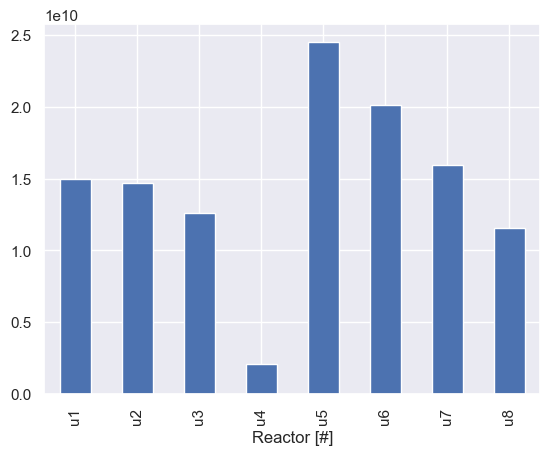

In [55]:
df.groupby('Reactor [#]')['ivcd [cell*day]'].sum().plot(kind='bar')

<AxesSubplot: xlabel='Reactor [#]'>

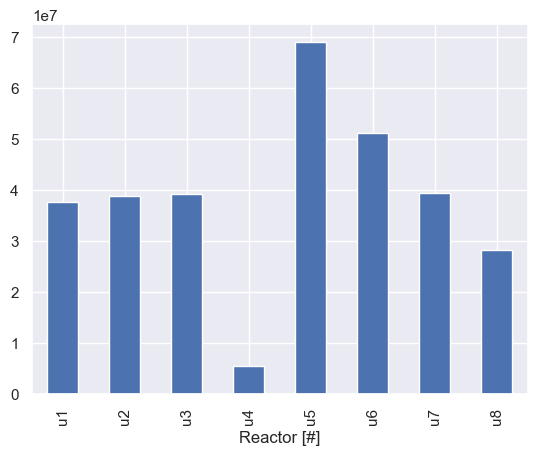

In [56]:
df.groupby('Reactor [#]')['Live (cells/ml) 2'].sum().plot(kind='bar')

In [57]:
df.to_csv("final.csv")